This Python Notebook demonstrates custom gradients and a custom loss function.

For this demo, the operation with custom gradient is an identity function, and it's custom gradient will flip the sign of the gradient. As a result, models that include this custom gradient will maximize the loss instead of minimizing it. So that this is visually clear, I will use a strange custom loss function, plotted below. The loss is minimized when the (ground truth) "actual output" is 5 less than the output predicted by the model and maximized when the "actual output" is 5 greater than the output predicted by the model.

In [1]:
import tensorflow as tf
def custom_loss(y_actual, y_pred):
    pred_rank = tf.rank(y_pred)
    if pred_rank > 1:
        return tf.math.reduce_sum(1/((y_actual - y_pred - 5)**2 + 3) - 1/((y_actual - y_pred + 5)**2 + 3),axis=tf.range(1,tf.rank(y_pred)))
    else:
        return 1/((y_actual - y_pred - 5)**2 + 3) - 1/((y_actual - y_pred + 5)**2 + 3)

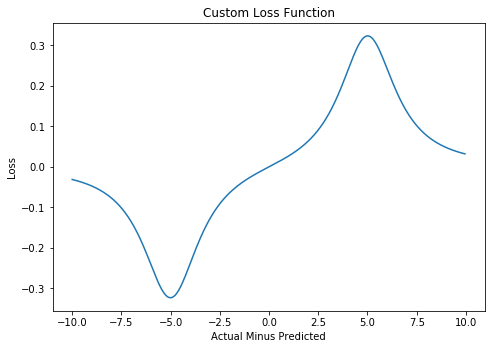

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np

y_actual = np.arange(-10,10,0.05)
y_predicted = np.zeros(y_actual.shape)

fig = plt.figure()
axs = fig.add_axes([0,0,1,1])
#loss = lambda act,pred: np.array([custom_loss(act[ii],pred[ii]) for ii in range(act.shape[0])])

axs.plot(y_actual - y_predicted,custom_loss(y_actual,y_predicted))
axs.set_title('Custom Loss Function')
axs.set_ylabel('Loss')
axs.set_xlabel('Actual Minus Predicted')

This first example does not include custom gradients. The custom loss has a minimum just below -0.3 and a maximum just above 0.3. It reaches its minimum when the model predicts outputs 5 larger than the "expected output."

The model learns as expected, successfully minimizing the loss.

In [2]:
import tensorflow as tf
import numpy as np
inputs = tf.keras.layers.Input(shape=(1,))
outputs = tf.keras.layers.Dense(units=1,use_bias=True)(inputs)
model = tf.keras.Model(inputs,outputs)
model.compile(loss = custom_loss)
x = np.random.randn(1000,1)
y = -2*x + 4
xval = np.random.randn(100,1)
yval = -2*xval + 4
model.fit(x=x,y=y,batch_size=10,epochs=96,validation_data = (xval,yval))
model.trainable_variables


Epoch 1/96
100/100 [==============================] - 0s 2ms/step - loss: 0.2268 - val_loss: 0.2163
Epoch 2/96
100/100 [==============================] - 0s 806us/step - loss: 0.2166 - val_loss: 0.2059
Epoch 3/96
100/100 [==============================] - 0s 884us/step - loss: 0.2070 - val_loss: 0.1960
Epoch 4/96
100/100 [==============================] - 0s 810us/step - loss: 0.1978 - val_loss: 0.1865
Epoch 5/96
100/100 [==============================] - 0s 852us/step - loss: 0.1891 - val_loss: 0.1775
Epoch 6/96
100/100 [==============================] - 0s 926us/step - loss: 0.1807 - val_loss: 0.1689
Epoch 7/96
100/100 [==============================] - 0s 898us/step - loss: 0.1725 - val_loss: 0.1602
Epoch 8/96
100/100 [==============================] - 0s 863us/step - loss: 0.1643 - val_loss: 0.1516
Epoch 9/96
100/100 [==============================] - 0s 868us/step - loss: 0.1559 - val_loss: 0.1430
Epoch 10/96
100/100 [==============================] - 0s 915us/step - loss: 0.1473 

Epoch 80/96
100/100 [==============================] - 0s 905us/step - loss: -0.2206 - val_loss: -0.2211
Epoch 81/96
100/100 [==============================] - 0s 880us/step - loss: -0.2310 - val_loss: -0.2323
Epoch 82/96
100/100 [==============================] - 0s 919us/step - loss: -0.2420 - val_loss: -0.2443
Epoch 83/96
100/100 [==============================] - 0s 865us/step - loss: -0.2535 - val_loss: -0.2565
Epoch 84/96
100/100 [==============================] - 0s 845us/step - loss: -0.2653 - val_loss: -0.2690
Epoch 85/96
100/100 [==============================] - 0s 942us/step - loss: -0.2774 - val_loss: -0.2815
Epoch 86/96
100/100 [==============================] - 0s 882us/step - loss: -0.2890 - val_loss: -0.2933
Epoch 87/96
100/100 [==============================] - 0s 783us/step - loss: -0.2999 - val_loss: -0.3042
Epoch 88/96
100/100 [==============================] - 0s 891us/step - loss: -0.3095 - val_loss: -0.3131
Epoch 89/96
100/100 [==============================] - 

[<tf.Variable 'dense/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-2.0008945]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([9.007946], dtype=float32)>]

This next cell includes a custom gradient.  The layer with a custom gradient does nothing to its input, but flips the sign of the gradient.

The result: the loss is maximized instead of minimized.

In [2]:
@tf.custom_gradient
def flip_grad(x):
    def grad(dy):
        return -dy
    return tf.identity(x), grad

class FlipGrad(tf.keras.layers.Layer):
    def __init__(self,*args,**kwargs):
        super().__init__(*args,**kwargs)
    def call(self,inputs):
        return flip_grad(inputs)

In [3]:
import tensorflow as tf
import numpy as np
inputs = tf.keras.layers.Input(shape=(1,))
preOutput = tf.keras.layers.Dense(units=1,use_bias=True)(inputs)
outputs = FlipGrad()(preOutput)
model = tf.keras.Model(inputs,outputs)
model.compile(loss = custom_loss)
x = np.random.randn(1000,1)
y = -2*x + 4
xval = np.random.randn(100,1)
yval = -2*xval + 4
model.fit(x=x,y=y,batch_size=10,epochs=96,validation_data = (xval,yval))
model.trainable_variables

Epoch 1/96
100/100 [==============================] - 0s 2ms/step - loss: 0.1772 - val_loss: 0.1764
Epoch 2/96
100/100 [==============================] - 0s 855us/step - loss: 0.1835 - val_loss: 0.1832
Epoch 3/96
100/100 [==============================] - 0s 928us/step - loss: 0.1902 - val_loss: 0.1906
Epoch 4/96
100/100 [==============================] - 0s 915us/step - loss: 0.1973 - val_loss: 0.1984
Epoch 5/96
100/100 [==============================] - 0s 909us/step - loss: 0.2047 - val_loss: 0.2062
Epoch 6/96
100/100 [==============================] - 0s 858us/step - loss: 0.2123 - val_loss: 0.2147
Epoch 7/96
100/100 [==============================] - 0s 831us/step - loss: 0.2204 - val_loss: 0.2235
Epoch 8/96
100/100 [==============================] - 0s 829us/step - loss: 0.2290 - val_loss: 0.2330
Epoch 9/96
100/100 [==============================] - 0s 856us/step - loss: 0.2378 - val_loss: 0.2425
Epoch 10/96
100/100 [==============================] - 0s 834us/step - loss: 0.2470 

[<tf.Variable 'dense/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-2.0002277]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([-1.008253], dtype=float32)>]

This next code cell defines the operation with the custom gradient inside the \_\_init\_\_ function of the custom layer. Like in the previous example, the sign of the gradient is flipped, and the model's fit function finds the weights and biases that maximize the loss.

In [2]:
class FlipGrad2(tf.keras.layers.Layer):
    def __init__(self,*args,**kwargs):
        @tf.custom_gradient
        def flip_grad2(x):
            def grad(dy):
                return -dy
            return tf.identity(x), grad
        super().__init__(*args,**kwargs)
        self.f = lambda x: flip_grad2(x)
    def call(self,inputs):
        return self.f(inputs)

In [3]:
import tensorflow as tf
import numpy as np
inputs = tf.keras.layers.Input(shape=(1,))
preOutput = tf.keras.layers.Dense(units=1,use_bias=True)(inputs)
outputs = FlipGrad2()(preOutput)
model = tf.keras.Model(inputs,outputs)
model.compile(loss = custom_loss)
x = np.random.randn(1000,1)
y = -2*x + 4
xval = np.random.randn(100,1)
yval = -2*xval + 4
model.fit(x=x,y=y,batch_size=10,epochs=96,validation_data = (xval,yval))
model.trainable_variables

Epoch 1/96
100/100 [==============================] - 0s 2ms/step - loss: 0.1478 - val_loss: 0.1365
Epoch 2/96
100/100 [==============================] - 0s 924us/step - loss: 0.1526 - val_loss: 0.1418
Epoch 3/96
100/100 [==============================] - 0s 959us/step - loss: 0.1577 - val_loss: 0.1472
Epoch 4/96
100/100 [==============================] - 0s 947us/step - loss: 0.1628 - val_loss: 0.1526
Epoch 5/96
100/100 [==============================] - 0s 913us/step - loss: 0.1683 - val_loss: 0.1581
Epoch 6/96
100/100 [==============================] - 0s 936us/step - loss: 0.1737 - val_loss: 0.1638
Epoch 7/96
100/100 [==============================] - 0s 929us/step - loss: 0.1793 - val_loss: 0.1696
Epoch 8/96
100/100 [==============================] - 0s 975us/step - loss: 0.1851 - val_loss: 0.1756
Epoch 9/96
100/100 [==============================] - 0s 982us/step - loss: 0.1910 - val_loss: 0.1819
Epoch 10/96
100/100 [==============================] - 0s 830us/step - loss: 0.1971 

[<tf.Variable 'dense/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-1.9998742]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([-1.0075637], dtype=float32)>]